# Attention Is All You Need

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/jamormoussa/docs/main/docs/images/llms/attention-is-all-you-need.png" width="500" />
</figure>

## Introduction

In 2017, Google researchers published a paper titled [**Attention Is All You Need**](https://arxiv.org/pdf/1706.03762), introducing a novel architecture called the **Transformer** in the context of machine translation tasks. This architecture has significantly influenced AI research and inspired many other applications.

The **Transformer** is at the heart of modern **Large Language Models** (LLMs), the most famous of which is [**ChatGPT**](https://chat.openai.com/) from [**OpenAI**](https://openai.com/). **ChatGPT** is based on the **GPT** architecture, which stands for **Generative Pre-trained Transformer** and serves as an assistant chatbot. Another notable application of the **Transformer** architecture is **BERT**, described in the [**BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding**](https://arxiv.org/pdf/1810.04805) paper. The **BERT** model is used in many tasks like sentiment analysis, question answering (Q&A), and more.

This tutorial will delve deep into the [**Attention Is All You Need**](https://arxiv.org/pdf/1706.03762) paper, exploring the **Transformer** architecture in depth, from theory to code.

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/jamormoussa/docs/main/docs/images/llms/transformer-arch.png" width="320" />  
  <figcaption> <b>Tranformer Architecture</figcaption>
</figure>

## 01. What's Motivation behind Transformers ?

**Recurrent neural networks (RNNs)** were once the state-of-the-art for sequence-to-sequence modeling. They are now used for handling sequence data in language modelling, speech recognition, machine translation, and more.

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/jamormoussa/docs/main/docs/images/llms/recurrent-net.png" width="140" />  
  <figcaption> <b>Recurrent Neural Networks Architecture</figcaption>
</figure>

**RNNs** are quite effective for handling small sequences. However, they lose efficiency when dealing with large sequences. To address this, **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)**, which are variants of **RNNs**, were introduced to tackle the vanishing gradients issue that arises with longer sequences. Despite these advancements, all RNN architectures still suffer from several issues:

- **RNNs are slow**: Due to their sequential nature, RNNs process inputs one at a time to generate the output. For example, to process the third token in a sequence, we must first process the first and second tokens. This sequential dependency makes both training and inference slow.

- **Gradient issues**: **Vanishing Gradient** and **Exploding Gradient** are significant problems with RNNs. Although **LSTMs** and **GRUs** were designed to mitigate these issues, they remain unavoidable when dealing with long contexts and sequences.

- **Context Representations**: The intermediate activation vectors passed from the previous hidden state $ h_t-1$ to the current hidden state $ h_t$ are meant to carry information from previous tokens. However, whether they accurately represent the context is uncertain, especially with long dependencies where information tends to be lost.


In the next sections, we will explore how **Transformers** address these issues using a clever trick called the **Attention Mechanism**.

## 02. Preliminaries

### 2.1 Understanding Tokenization in Language Modeling

First of all, before we dive into understanding what tokenization is, I want to mention that **Andrej Karpathy** created a great video on this topic.

You can find it here [https://www.youtube.com/watch?v=zduSFxRajkE](https://www.youtube.com/watch?v=zduSFxRajkE).

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/jamormoussa/docs/main/docs/images/llms/tokenizer-andrej.png"/>  
  <figcaption> <b> Let's build the GPT Tokenizer </figcaption>
</figure>

#### What's Tokenization ?

In simple terms, **Tokenization** is breaking sequences into smaller **tokens**. These tokens can vary in size, ranging from single letters to sub-words, words, or even multiple words. Each token is assigned an integer representing its unique identifier, or `id`.

The **Tokenization** stage is very critical before plugging text sequences naively into the language models; without it, they won't work.

You can actually test the tokenization online by visiting the following website: [tiktokenizer](https://tiktokenizer.vercel.app/?model=o200k_base). After entering some text, you can see that the sequence is broken into tokens on the right, with different colors.

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/jamormoussa/docs/main/docs/images/llms/tokenizer-tiktoten.png"/>  
  <figcaption> <b>Tiktoken Vercel App</figcaption>
</figure>

#### Why Tokenization is important?

<div class="admonition question" markdown>
    <p class="admonition-title">Question</p>
    <p>
    A very good question that can be asked at this moment is, <b>why don't we just consider words as tokens, separated by white space?</b>
    </p>
  </div>

It's very convenient and logical to consider why complicate things by breaking words into sub-words, etc.

In simple terms, if we consider tokens as just words separated by white space, we'll encounter a couple of issues:

- Firstly, the text sequences we work with are not always written in a high-quality format. For example, if the sequence contains something like `Attention isallyou need,` we would consider `isallyou` as one word, but it's three different words. Therefore, we need a clever way to tokenize the sequence.

- Secondly, tokenization determines the vocabulary, which consists of unique tokens. If we consider tokens just words, we end up with a huge vocabulary size, potentially in the order of **hundreds of thousands** or even **millions**. This can be challenging when dealing with language modeling. However, if we consider tokens as just characters, we end up with a vocabulary size of around a hundred. This is not sufficient for effective language modeling. Therefore, the solution is to find a trade-off between the two.

In the tutorial **Let's build the GPT Tokenizer**, **Andrej Karpathy** raises some issues with **LLMs** due to bad **Tokenization**, here are some of them:

- Why can't LLM spell words?
- Why can't LLM perform super simple string processing tasks like reversing a string?
- Why is LLM worse at non-English languages (e.g. Japanese)?
- Why is LLM bad at simple arithmetic?
- Why did GPT-2 have more than necessary trouble coding in Python?

#### Tokenization in code

In fact, there are many tokenizers available, and each LLM comes with its own tokenizer. For OpenAI, it uses [tiktoken](https://github.com/openai/tiktoken) for their GPT LLMs, which is based on the [Byte Pair Encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) algorithm. Google uses [SentencePiece](https://github.com/google/sentencepiece), an unsupervised text tokenizer.

In this section, we're going to use a toy examples with **tiktoken**.

First, let's install the `tiktoken` library.

In [4]:
!pip install tiktoken

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tiktoken from https://files.pythonhosted.org/packages/61/b4/b80d1fe33015e782074e96bbbf4108ccd283b8deea86fb43c15d18b7c351/tiktoken-0.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.2 MB/s eta 0:00:00m eta 0:00:010:00:010m


Next, import the library and load the tokenizer for `gpt2`.

In [5]:
import tiktoken

encoder = tiktoken.get_encoding("gpt2")

In [6]:
encoder

<Encoding 'gpt2'>

Now, let's use the `gpt2` tokenizer to encode the text `hello everyone` and then decode it.

In [22]:
code = encoder.encode("hello everyone")
code

[31373, 2506]

In [23]:
[encoder.decode([c]) for c in code]

['hello', ' everyone']

### 2.2 Understanding Embeddings

Nowadays, AI technologies are used no matter the data type and task you have. The reason behind it from my perspective, is **Embeddings**.

**Embeddings** are numerical representations of real-world objects, and data. They are used to capture the **semantic** and **Syntatic relationships**, and then later these embeddings are used by ML/AI systems to learn more complex patterns, and relationships.

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/jamormoussa/docs/main/docs/images/llms/vector-embeddings.png" width="700" />  
  <figcaption> <b>Vector Embeddings</figcaption>
</figure>

Before, starting to dive into the details, Here are two blogs for further information.

- **Amazon AWS** : [What Are Embeddings In Machine Learning?](https://aws.amazon.com/what-is/embeddings-in-machine-learning/).
- **OpenAI**: [Introducing text and code embeddings](https://openai.com/index/introducing-text-and-code-embeddings/)

#### Why are Embeddings important?

Well, the short answer is we cannot plug data, i.e. text, images, audio, etc, into machine learning algorithms as they are. Instead, a preprocessing stage is needed, in which data is converted into some numerical representations, **Embeddings**.

That means machine learning algorithms can be used for different purposes and handling data no matter their type.

Embeddings are used for many purposes, let's explore some of them.

- **Dimensionality Reduction**: In that case, embeddings are used to encode and compress some high-dimension data into low-dimension space. Which helps a lot to reduce complexity, and makes algorithms fast in training and inference.

- **Large Language Models**: Retrieve Augmented Generation **(RAG)** helps LLMs generate more facts by providing them with factual inputs, similar to the user's query, for this similarity we use embeddings.

For further information about **RAG**, I suggest checking a great tutorial [Local Retrieval Augmented Generation (RAG) from Scratch](https://www.youtube.com/watch?v=qN_2fnOPY-M) made by **Daniel Bourke**.

#### How are Embeddings Created?

Embeddings are created, by training Neural Networks to encode the information into dense representation in a multi-dimention space.

Let's explore some neural network architectures used for learning embeddings for text data.

- **Word2Vec**: This architecture is proposed by Google in two versions, **Continuous Bag of Words (CBOW)** and **Skip-Gram**. With the CBOW method, embeddings are learned by performing classification tasks. Given a context size, called window size `w`, we predict the word in the middle.

- **BERT**: is a Transformer-based architecture. It is trained on massive data to understand language by performing two tasks: **Language Masking** and **Next Sentence Prediction**.

A simple difference between **Word2Vec** and **BERT**, is that **Word2Vec** cannot distinguish contextual differences of the same word used to imply different meanings. On the other hand, **BERT** can change the embeddings of a token (word) depending on the context. 

#### Embeddings in code

Let's explore the word embeddings in code. First, we import `gensim` library will provide pre-trained word embeddings, like `glove-twitter-25` that encode each word into a dense vector of 25 dimensions.

In [1]:
import gensim.downloader
import numpy as np

In [2]:
glove = gensim.downloader.load('glove-twitter-25')

After downloading and load the `glove-twitter-25` word embeddings model, let's find the most similar to word **king**.

In [3]:
glove.most_similar("king")

[('prince', 0.9337409734725952),
 ('queen', 0.9202421307563782),
 ('aka', 0.9176921844482422),
 ('lady', 0.9163240790367126),
 ('jack', 0.9147354364395142),
 ("'s", 0.9066898226737976),
 ('stone', 0.8982374668121338),
 ('mr.', 0.8919409513473511),
 ('the', 0.889343798160553),
 ('star', 0.8892088532447815)]

Beautiful, we can see that **prince** and **queen** are on top of the list. That shows how these vector representations capture the meaning of the word.

<div class="admonition note" markdown>
    <p class="admonition-title">Note</p>
    <p>
       We can see on the list that, <b>'s</b> is similar to the word <b>king</b> with <b>90.66%</b>. Is not make sense, right? 
    </p>
    <p>
        The raison is that the quality of the embeddings depends on the quality of data, the NNs architecture used and more, as you can notice that the data used for the training comes form the twitter. That explains why we get this results.
    </p>
  </div>

Let's define the cosine similarity metric that measure the angle between two vectors.

In [4]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))

Let's have fun and play with some embeddings vectors, to replicate the famous equation `king = queen + man - woman` and see what we can get.

In [15]:
man = glove.get_vector("man")
woman = glove.get_vector("woman")

In [16]:
king = glove.get_vector("king")
queen = glove.get_vector("queen")

First, let's take look to the embeddings of the word `king`

In [12]:
king

array([-0.74501 , -0.11992 ,  0.37329 ,  0.36847 , -0.4472  , -0.2288  ,
        0.70118 ,  0.82872 ,  0.39486 , -0.58347 ,  0.41488 ,  0.37074 ,
       -3.6906  , -0.20101 ,  0.11472 , -0.34661 ,  0.36208 ,  0.095679,
       -0.01765 ,  0.68498 , -0.049013,  0.54049 , -0.21005 , -0.65397 ,
        0.64556 ], dtype=float32)

As you can see the token (word) king, is represented as a dense vector of type `float32`. With this representation, we can now compute the similarity between different embeddings, the following code snippet calculates the cosine similarity between `king` and `man` embeddings.

In [13]:
cosine_similarity(man, king)

0.7666067

In [14]:
cosine_similarity(queen + man - woman , king)

0.7310066

### 2.3 From Tokenization to Embeddings

As seen, in the section about tokenization, it is a process of breaking sequences into small pieces called tokens. As we covered many of the issues with LLMs come from bad tokenization.

Now, after breaking the sequences into a list of tokens, we cannot directly plug them into a model as they are, because models understand only numbers, and vectors, i.e. **Embeddings**.

So, the process is too simple, we map each token with embedding representations, that capture the semantic meaning of that specific token. These Embeddings are randomly initialized in the first place but will be learned during the training.

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/jamormoussa/docs/main/docs/images/llms/tik_to_emb.png" width="400" />  
  <figcaption> <b>From Tokenization to Embeddings</figcaption>
</figure>

At last, we have arrived at this place, to talk about **Transformers**, I think we have covered all we need to start this topic. So, in the next sections, we're trying to explain all the building blocks of the transformer architecture.

### 2.4 Understanding Weighted Aggregation 

**Weighted Aggregation** is a key concept to fully understand the **Attention Mechanism** in this section. we're going to cover an inefficient and efficient way to perform aggregation.

#### What's Aggregation in Machine Learning ?

**Aggregation** can be defined as the process of collecting data and information from different sources and presenting them in summarized form.

This concept can be found in many machine learning algorithms. For instance, consider a single neuron in a multi-layer perceptron (MLP). The output of the neuron is computed as a weighted sum of the input vectors, which is a form of aggregation:

$$
z = \sum_{i} w_i x_i
$$

Convolutional Neural Networks (CNNs) aggregate information by applying a kernel to an image, combining pixel values from the neighborhood to the center pixel. Similarly, Graph Neural Networks (GNNs) aggregate information through message passing, combining data from neighboring nodes.

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/jamormoussa/docs/main/docs/images/llms/conv_opt.gif" width="400" />  
  <figcaption> <b>Convolution operation</figcaption>
</figure>

#### Weighted Aggregation (an Inefficient version)

Before tackling the **Weighted Aggregation**, we're going step by step to introduce the concept while considering simple examples at the beginning.

For instance, consider a list `a` with three values, we want at each item in the array `a`. We sum up all items from the beginning to the current item, then return the result as a new array. The computations are illustrated as follows:

$$
\begin{align*}
c_0 &= a_0 = 1 \\
c_1 &= a_0 + a_1 = 1 + 2 = 3 \\
c_2 &= a_0 + a_1 + a_2 = 1 + 2 + 3 = 6
\end{align*}
$$

Beautiful, let's see this in code.

In [1]:
import numpy as np

In [9]:
a = np.array([1, 2, 3])

In [10]:
c = np.array([np.sum(a[:i+1]) for i in range(len(a))])
c

array([1, 3, 6])

In the previous example, we used sum aggregation. But what if we want to use a different form of aggregation, such as **average**? We can achieve this by dividing the sum of the elements by the number of elements.

$$
\begin{align*}
c_0 &= \frac{a_0}{1} = \frac{1}{1} = 1 \\
c_1 &= \frac{a_0 + a_1}{2} = \frac{1 + 2}{2} = \frac{3}{2} = 1.5 \\
c_2 &= \frac{a_0 + a_1 + a_2}{3} = \frac{1 + 2 + 3}{3} = \frac{6}{3} = 2
\end{align*}
$$


In [11]:
np.array([sum(a[:i+1])/(i+1) for i in range(len(a))])

array([1. , 1.5, 2. ])

In fact, in the **Average Aggregation**, we multiply each element with a fix **weight** $w = \frac{1}{\text{num elements}}$, here where the **Weighted Aggregation** comes, at each iteration $i$ it performs aggregation of element $j$ with $w_{ij}$, and we have 

$$ \forall i \hspace{0.2cm} \sum_{j}^{}w_{ij} = 1$$

$$ \forall i \hspace{0.2cm} c_i = \sum_{j}^{} w_{ij} a_j$$

Now, let's see all this in code.

In [12]:
a

array([1, 2, 3])

In [13]:
w = [[1], [0.5, 0.5], [0.1, 0.4, 0.5]]
w

[[1], [0.5, 0.5], [0.1, 0.4, 0.5]]

In [14]:
c = [ sum(w[i][j] * a[j] for j in range(len(a[:i+1]))) for i in range(len(a))]
c

[1, 1.5, 2.4]

<div class="admonition question" markdown>
    <p class="admonition-title">Question</p>
    <p>
    You may now ask, <b>Why and When we will need this?</b>   
    </p>
</div>

Great question, the answer is that we're building the concepts that we'll need to understand the **Attention Mechanism** so make sure that you understand these key ideas.

<div class="admonition tip" markdown>
    <p class="admonition-title">Keep In Mind</p>
    <p>The most important thing to keep in mind. <b> Weighted Aggregation </b> is a way to aggregate previous information, but in a weighted way which means we define how much each element can contribute. 
    </p>
</div>

#### Weighted Aggregation (An effecient Way)

In the previous section we performed, weighted aggregation using for loops which isn't efficient. There is a better way to turn it into matrix multiplication?   

Hey, what just turning it into matrix multiplication makes this operation efficient?

The short answer is yes! I'll explain. Computers excel at performing linear algebra. **GPU** hardware is specifically optimized to handle matrix multiplication and linear algebra operations with high efficiency.

For more information, check out:

- **Why linear algebra and GPUs are the bedrock of machine learning** [https://b-yarbrough.medium.com/why-linear-algebra-and-gpus-are-the-bedrock-of-machine-learning-4a55baac2897](https://b-yarbrough.medium.com/why-linear-algebra-and-gpus-are-the-bedrock-of-machine-learning-4a55baac2897)

Now, let's back to our main topic here.

The key idea is to construct the `w` as the upper triangular portion as shown in the following code snippet.

In [15]:
w = np.array([[1  ,   0,   0],
              [0.5, 0.5,   0],
              [0.1, 0.4, 0.5]])
w

array([[1. , 0. , 0. ],
       [0.5, 0.5, 0. ],
       [0.1, 0.4, 0.5]])

Then multiply this matrix with the `a` array, which we have before

In [16]:
a

array([1, 2, 3])

In [17]:
w @ a

array([1. , 1.5, 2.4])

WooW, As we can see. We've just done the same thing as we did before. It is easy to get, right? 

The last thing I want to explain in this section.

What if `a` is not a vector but a matrix, the aggregation will be performed with respect to rows. This can be done by changing only the value of `a`, let's have a simple example.

In [21]:
a = np.array([[1, 4],
              [2, 5],
              [3, 6]])
a

array([[1, 4],
       [2, 5],
       [3, 6]])

In [22]:
# define out
w = np.array([[1  ,   0,   0],
              [1/2, 1/2,   0],
              [1/3, 1/3, 1/3]])
w

array([[1.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        ],
       [0.33333333, 0.33333333, 0.33333333]])

In [23]:
w @ a

array([[1. , 4. ],
       [1.5, 4.5],
       [2. , 5. ]])

<!-- ### Extra-curriculum
- **Attention, Transformers, and GPT** (Medium Blog) [https://trevormcguire.medium.com/attention-transformers-and-gpt-b3adbbb4a950](https://trevormcguire.medium.com/attention-transformers-and-gpt-b3adbbb4a950) -->

Until now, we've covered many basic concepts but they are essential! such as **Tokenization**, **Embeddings**, **Weighted Aggregation**. 

Now, we're diving into the Transformer architecture. Initially, we'll explore the **Embedding layer** and delve into **Positional Encoding**. Following this, we'll delve into the **Attention Mechanism**.

## 03. Transformer - Embedding Layer

### 3.1 What an Embedding Layer is ?

**Embedding Layer** is a looking table of dimensions **vocabulary size** and **Embedding Dimension**, the embeddings dimension denoted in the original paper as $d_{model} = 512$.

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/jamormoussa/docs/main/docs/images/llms/emb_layer.png" width="400" />  
  <figcaption> <b>Embedding Layer & Positional Encoding</figcaption>
</figure>

This Embedding layer accepts a tenor of indexes (tokens) as input and returns the corresponding embedding vectors. `PyTorch` has a built-in embedding layer from the `nn` module.

### 3.2 Embedding Layer in Code

First, we import the `torch` as `torch.nn` module, and `tiktoken` library to use `gpt2` tokenizer.

In [71]:
import torch, torch.nn as nn
import tiktoken

Let's get the `gpt2` tokenizer

In [72]:
tokenizer = tiktoken.get_encoding("gpt2")

the `gpt2` tokenizer has `50257` in the vocabulary size.

In [73]:
tokenizer.n_vocab

50257

Now, let's create an instance of the embeddings layer from the `nn` module, specifying two arguments.

- `num_embeddings` represents the vocabulary size, and we can set its value equal to `tokenizer.n_vocab`.
  
- `embeddings_dim`: represents how many dimensions you want to use to represent tokens.

In [74]:
emb_layer = nn.Embedding(
    num_embeddings= tokenizer.n_vocab, # voab_size of gpt2 tokenizer
    embedding_dim= 512 # d_model: embeddings dimension
)

Let's consider that we have the following sentence `Hi my name is Moussa`, in which we encode using the `gpt2` tokenizer. then we get the following `sequence`.

In [75]:
sentence = tokenizer.encode("Hi my name is Moussa")
sentence

[17250, 616, 1438, 318, 42436, 11400]

In [76]:
sequence = torch.LongTensor([sentence]) # LongTensor to ensure that indexes are integers.
sequence

tensor([[17250,   616,  1438,   318, 42436, 11400]])

In [77]:
sequence.shape

torch.Size([1, 6])

The `sequence` tensor is of shape `(1, 6)`, the first dimension represents the **batch** dimension, here `batch = 1` because we have a single sentence. The second dimension is the length of your sequence, also called the **Time** dimension.

In [78]:
embeddings = emb_layer(sequence)
embeddings

tensor([[[-0.8604,  0.2464,  2.5279,  ..., -1.5272,  1.4942,  0.6481],
         [ 1.7703, -1.0316,  0.8046,  ...,  0.3494,  0.2895, -1.6490],
         [-0.7849, -1.7873, -0.4447,  ...,  0.9301,  0.4982, -1.4281],
         [-0.3122,  0.4844,  0.0659,  ...,  0.0458, -0.3955, -0.0980],
         [-0.8068, -0.3864,  0.0838,  ..., -1.3389,  0.2242,  0.1750],
         [-1.1558, -0.2892, -1.2714,  ..., -0.4282, -2.8925, -1.1820]]],
       grad_fn=<EmbeddingBackward0>)

As you can see, the embeddings layer has grad function`grad_fn=<EmbeddingBackward0>`, which indicates that it is trainable. These embeddings will be changed and updated during the back-propagation.

In [79]:
embeddings.shape

torch.Size([1, 6, 512])

Let's debug the shape of embeddings with the form of `(B, T, d_model)`.

- **`B`**: represents the batch dimension. how many sentences or sequences do you want to feed the transformer? The batch dimension has a nice property. All sequences are independent of each other, which allows us to process them in parallel and benefit from the computer's power.
  
- **`T`**: is the Time dimension, which represents the length of the sequence. How many tokens are in the sequence? The time dimension is considered a batch dimension in the context of using the transformer's architecture (key characteristic), as all tokens are fed at the same time.
  
- **`d_model`**: called embeddings dimension, or number of channels. It represents how many dimensions you use to describe the tokens. 

## 04. Transformer - Positional Encoding

### 4.1 What's & Why Potional Encoding ?

In the upcoming section on the **Attention Mechanism**, we will see that tokens are fed into the transformer architecture in parallel, without performing any recurrent or convolutional operations. This parallel processing is what makes transformer architectures more efficient and faster to train compared to sequential models like **RNNs** (e.g., GRU and LSTMs).

However, this parallel processing introduces a challenge: it doesn't capture the order of tokens (sequence data). **Positional Encoding** addresses this issue by encoding and mapping each position with a vector of the same dimension as the token embedding dimension (`d_model`). Before feeding the token into the transformer, we add two vectors: the token embedding and the positional encoding of the corresponding position.

Several requirements need to be considered for positional encoding:

1. The encodings should not depend on the input tokens.
2. The values of the encodings should be small to avoid overshadowing the semantic representation obtained from the token embedding.
3. The encodings should be distinct.

To encode positional information, we need a function that provides values within a close range. The **sigmoid** function maps any real number to values between 0 and 1:

$$
    \forall x \in \mathbb{R} \hspace{0.5cm} \sigma(x) \in [0, 1]
$$

However, the sigmoid function has a limitation: for large values, it converges to 1, which is not suitable for handling long sequences.

In the original paper, they proposed using sinusoidal functions because they oscillate between -1 and 1, meeting the requirement of not exceeding the range, even as the input grows infinitely. Therefore, the positional encoding is represented as a matrix $PE \in \mathbb{R}^{n \times d\_model}$, defined as:

$$
\forall i \in \left[0, \frac{d\_model}{2}\right] \left\{
\begin{align*}
PE_{pos, 2i} &= \sin\left(\frac{pos}{10000^{\frac{2i}{d\_model}}}\right) \\
PE_{pos, 2i+1} &= \cos\left(\frac{pos}{10000^{\frac{2i}{d\_model}}}\right)
\end{align*}
\right.
$$

For each dimension, a different frequency is used to ensure that the encodings are distinct from each other. The following animation illustrates this concept:

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/JamorMoussa/docs/dev/docs/images/llms/pos-encoding.gif"/>  
  <figcaption> <b>Positional Encoding Animation</figcaption>
</figure>

For more details about the animation check the following Tutorial: [How positional encoding in transformers works?](https://www.youtube.com/watch?v=T3OT8kqoqjc)

### 4.2 Positional Encoding in Code 

Now, let's see positional encoding in pytorch code 😁.

First of all, we need to import the `PyTorch` framework as well as `numpy` for numerical computation, the `matplotlib` and `seaborn` for making some plots later.

In [5]:
import torch, torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

As has been said Positional Encoding is represented by matrix $PE \in \mathbb{R}^{n \times d\_model}$, where $n$ represents the context size, and the $d\_model$ represents the embedding dimension.

In [4]:
block_size = 1024 # represent the context size <=> n.
d_model = 512

For instance, let's initialize the `pe` matrix of zeros, it has the shape of `block_size`, which represents the context size, and finally `d_model`.

In [45]:
pe = torch.zeros(block_size, d_model)
pe[:5]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [46]:
pe.shape

torch.Size([1024, 512])

We remind you of the formula, with some changes in which we set `f_i` as the frequency.
$$
\forall i \in \left[0, \frac{d\_model}{2}\right] \left\{
\begin{align*}
PE_{pos, 2i} &= \sin\left(\frac{pos}{10000^{\frac{2i}{d\_model}}}\right) &= \hspace{0.2cm} \sin\left(f_i pos\right)\\
PE_{pos, 2i+1} &= \cos\left(\frac{pos}{10000^{\frac{2i}{d\_model}}}\right)  &=  \hspace{0.2cm} \cos\left(f_i pos\right)
\end{align*}
\right.
$$


Where

$$
\forall i \in \left[0, \frac{d\_model}{2}\right] \mid f_i = \frac{1}{10000^{\frac{2i}{d\_model}}}
$$

let's start with `pos` which ranges from 0 to the context size `block_size`.

In [6]:
pos = torch.arange(0, block_size).unsqueeze(1)
pos

tensor([[   0],
        [   1],
        [   2],
        ...,
        [1021],
        [1022],
        [1023]])

For the implementation concerns, we're rewriting the frequency `f_i` formula, with `exp` and `log` functions.

$$
\forall i \in \left[0, \frac{d\_model}{2}\right] \mid f_i = \frac{1}{10000^{\frac{2i}{d\_model}}} = \exp\left[-2i \frac{\log{10000}}{d\_model}\right]
$$


In [179]:
freq = torch.exp(
    - torch.arange(0, d_model, 2) * torch.log(torch.Tensor([10000])) / d_model
)
print("freq shape:", freq.shape)
freq[:50]

freq shape: torch.Size([256])


tensor([1.0000, 0.9647, 0.9306, 0.8977, 0.8660, 0.8354, 0.8058, 0.7774, 0.7499,
        0.7234, 0.6978, 0.6732, 0.6494, 0.6264, 0.6043, 0.5829, 0.5623, 0.5425,
        0.5233, 0.5048, 0.4870, 0.4698, 0.4532, 0.4371, 0.4217, 0.4068, 0.3924,
        0.3786, 0.3652, 0.3523, 0.3398, 0.3278, 0.3162, 0.3051, 0.2943, 0.2839,
        0.2738, 0.2642, 0.2548, 0.2458, 0.2371, 0.2288, 0.2207, 0.2129, 0.2054,
        0.1981, 0.1911, 0.1843, 0.1778, 0.1715])

The shape of `freq` is equal to $\frac{d\_model}{2}$, because in half of the dimensions we use `cos` (for odd dimensions), the rest `sin` is used.

In [181]:
pos_freq = pos * freq
print(pos_freq.shape)
pos_freq 

torch.Size([1024, 256])


tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 9.6466e-01, 9.3057e-01,  ..., 1.1140e-04, 1.0746e-04,
         1.0366e-04],
        [2.0000e+00, 1.9293e+00, 1.8611e+00,  ..., 2.2279e-04, 2.1492e-04,
         2.0733e-04],
        ...,
        [1.0210e+03, 9.8492e+02, 9.5011e+02,  ..., 1.1374e-01, 1.0972e-01,
         1.0584e-01],
        [1.0220e+03, 9.8588e+02, 9.5104e+02,  ..., 1.1385e-01, 1.0982e-01,
         1.0594e-01],
        [1.0230e+03, 9.8685e+02, 9.5198e+02,  ..., 1.1396e-01, 1.0993e-01,
         1.0605e-01]])

Now we select all rows, with each row representing a token position. For all even dimensions, we map the `sin` function to `pos_freq`, and for odd dimensions, we map the `cos` function.

In [52]:
pe[:, 0::2] = torch.sin(pos_freq)
pe[:, 1::2] = torch.cos(pos_freq)

In [182]:
print(pe.shape)
pe

torch.Size([1024, 512])


tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
          1.0366e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
          2.0733e-04,  1.0000e+00],
        ...,
        [ 1.7612e-02, -9.9984e-01, -9.9954e-01,  ...,  9.9399e-01,
          1.0564e-01,  9.9440e-01],
        [-8.3182e-01, -5.5504e-01, -5.4462e-01,  ...,  9.9398e-01,
          1.0575e-01,  9.9439e-01],
        [-9.1649e-01,  4.0007e-01,  3.7901e-01,  ...,  9.9396e-01,
          1.0585e-01,  9.9438e-01]])

<Axes: >

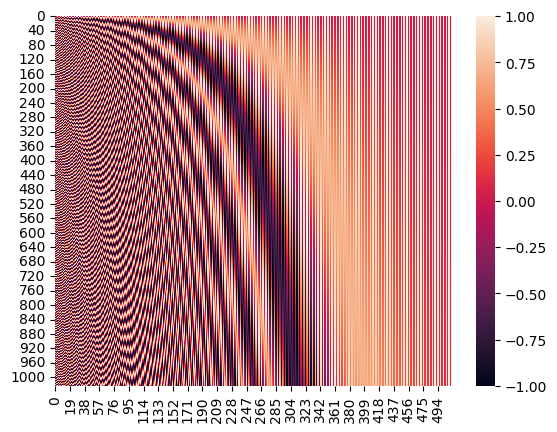

In [183]:
sns.heatmap(pe.numpy())

### 4.3 Positional Encoding PyTorch Module

Let's create the `PositionalEncoding` PyTorch module that combines everything we've discussed previously.

The `PositionalEncoding` module defines a `forward` function, which accepts an input along with the corresponding position encoding.

In [184]:
class PositionalEncoding(nn.Module):


    def __init__(self, block_size: int = 20, d_model: int = 1):
        super(PositionalEncoding, self).__init__()
        
        self.block_size: int = block_size
        self.d_model: int = d_model

        pe = torch.zeros(self.block_size, self.d_model)
        
        pos = torch.arange(0, self.block_size).unsqueeze(1) 

        freq = torch.exp(
            - torch.arange(0, self.d_model, 2) * torch.log(torch.Tensor([10000])) / self.d_model
        )

        pe[:, 0::2] = torch.sin(pos * freq) # for Even positions
        pe[:, 1::2] = torch.cos(pos * freq) # for Odd positions
        
        self.register_buffer('pe', pe)
        
    def forward(self, input: torch.Tensor) -> torch.Tensor:

        return input + self.pe[:, :input.size(1)]

Now, let's create an instance of the `PositionalEncoding` module. We will set the context size to 100 and the embedding dimension (`d_model`) to 20.

In [185]:
pos_encoding = PositionalEncoding(
                block_size = 100,
                d_model= 20
            )

In [186]:
pos_encoding

PositionalEncoding()

To test the positional encoding object, we'll first create an `input` tensor filled with zeros, having a shape of `(batch = 1, block_size = 100, d_model = 20)`.

In [187]:
input = torch.zeros(1, 100, 20)

In [188]:
out = pos_encoding(input)
out

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  3.8767e-01,  ...,  1.0000e+00,
           2.5119e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  7.1471e-01,  ...,  1.0000e+00,
           5.0238e-04,  1.0000e+00],
         ...,
         [ 3.7961e-01, -9.2515e-01,  7.9395e-01,  ...,  9.9813e-01,
           2.4363e-02,  9.9970e-01],
         [-5.7338e-01, -8.1929e-01,  9.6756e-01,  ...,  9.9809e-01,
           2.4614e-02,  9.9970e-01],
         [-9.9921e-01,  3.9821e-02,  9.8984e-01,  ...,  9.9805e-01,
           2.4865e-02,  9.9969e-01]]])

In [189]:
out.shape

torch.Size([1, 100, 20])

The plot shows selected dimensions of the positional encoding, illustrating their periodic patterns. It visualizes dimensions 2, 4, 6, and 8, highlighting how they oscillate with different frequencies.

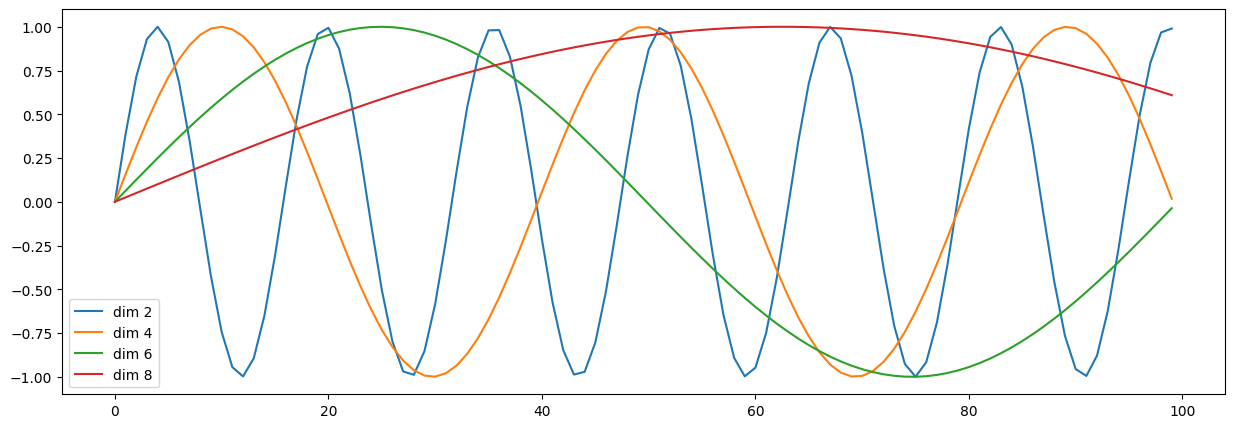

In [190]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), out[0, :, 2:10:2].data.numpy())
plt.legend(["dim %d"%p for p in range(2, 10, 2)])

### 4.4 Positional Encoding with `nn.Embedding`

A technical detail here: we've discussed how to compute the positional encoding table using periodic functions `cos` and `sin`. However, this is not critical. It can be set as an **Embedding table** and learned from the data. In the original paper, **Attention Is All You Need**, the authors mention that in their experiments, they set learnable positional embeddings and achieved nearly identical results.

<figure markdown="span">
    <center>
  <img src="https://raw.githubusercontent.com/JamorMoussa/docs/dev/docs/images/llms/learnable-pos-encoding.png"/>  
  <figcaption> <b>Learnable Positional Encoding</figcaption>
</figure>